In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
import optuna
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")
print("Path to dataset files:", path)
df = pd.read_csv(f'{path}/vehicles.csv')
df.head()

Path to dataset files: /home/mathias/.cache/kagglehub/datasets/austinreese/craigslist-carstrucks-data/versions/10


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [5]:
df = df[(df['price'] > 1000) & (df['price'] < 100000)]

In [6]:
df[df['odometer'] == 0]['condition'].value_counts()

condition
excellent    444
good          77
fair          23
like new      10
new            7
salvage        4
Name: count, dtype: int64

In [7]:
df = df[(df['odometer'] > 0) & (df['odometer'] <= 400000)]

In [8]:
df.describe()


,id,price,year,odometer,county,lat,long
count,3.742730e+05,374273.000000,373196.000000,374273.000000,0.0,370929.000000,370929.000000
mean,7.311463e+09,19422.409322,2011.070593,92746.401969,NaN,38.513941,-94.199890
std,4.390185e+06,14294.701212,9.418896,63205.719173,NaN,5.836996,18.044333
min,7.301583e+09,1003.000000,1900.000000,1.000000,NaN,-81.838232,-159.719900
25%,7.308065e+09,7995.000000,2008.000000,38528.000000,NaN,34.720000,-110.697400
50%,7.312550e+09,15995.000000,2013.000000,87500.000000,NaN,39.234920,-87.960000
75%,7.315239e+09,27990.000000,2017.000000,135430.000000,NaN,42.350000,-80.790000
max,7.317101e+09,99999.000000,2022.000000,400000.000000,NaN,82.390818,167.629911


In [9]:
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [10]:
missing = df.isna().mean() * 100
cols_keep = missing[missing < 5].index.tolist()

if cols_keep:
    df.dropna(subset=cols_keep, inplace=True)

In [11]:
df.isna().mean() * 100

id                0.000000
url               0.000000
region            0.000000
region_url        0.000000
price             0.000000
year              0.000000
manufacturer      0.000000
model             0.000000
condition        37.014447
cylinders        41.158822
fuel              0.000000
odometer          0.000000
title_status      0.000000
transmission      0.000000
VIN              37.809107
drive            29.631598
size             71.769804
type             21.012321
paint_color      27.520055
image_url         0.000000
description       0.000000
county          100.000000
state             0.000000
lat               0.000000
long              0.000000
posting_date      0.000000
dtype: float64

In [12]:
df['year'] = df['year'].astype('int32')

In [13]:
set_remove = ['id', 'url', 'region_url', 'image_url', 'county', 'size']
df.drop(columns=set_remove, inplace=True, errors = "ignore")

Text(0.5, 1.0, 'Top 10 modelos más comunes')

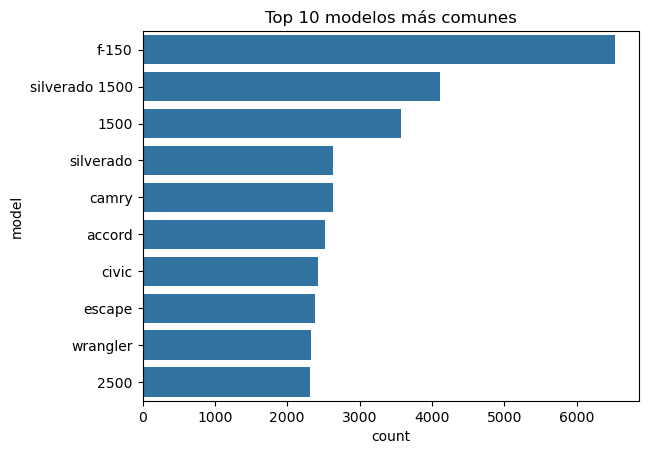

In [14]:
top_model = df['model'].value_counts().head(10).index

sns.countplot(data=df[df['model'].isin(top_model)], y='model', order=top_model)
plt.title('Top 10 modelos más comunes')


<Axes: xlabel='condition', ylabel='count'>

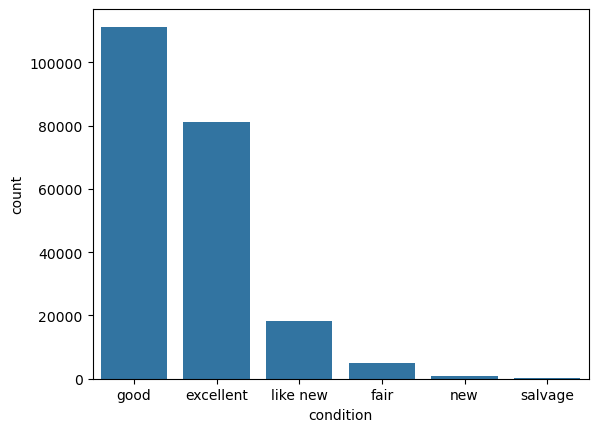

In [15]:
sns.countplot(data = df, x = 'condition', order = df['condition'].value_counts().index)

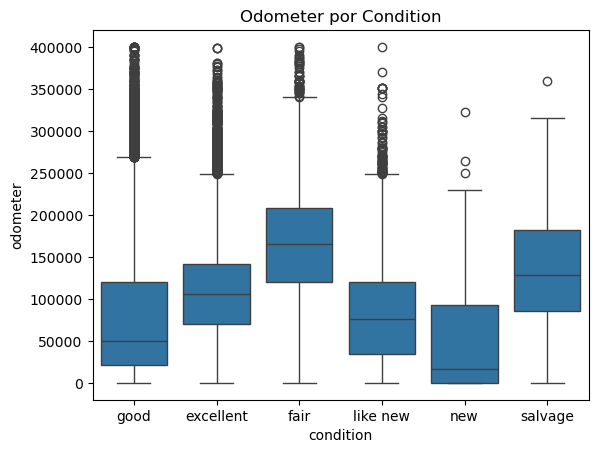

In [16]:
sns.boxplot(data=df, x='condition', y='odometer')
plt.title('Odometer por Condition')
plt.show()


In [17]:
def odometer_to_category(x):
    if x <= 20000:
        return 'muy_poco_uso'
    elif x <= 60000:
        return 'poco_uso'
    elif x <= 120000:
        return 'uso_medio'
    elif x <= 200000:
        return 'muy_usado'
    else:
        return 'altisimo_uso'

df['odo_cat'] = df['odometer'].apply(odometer_to_category)

<Axes: xlabel='odo_cat', ylabel='count'>

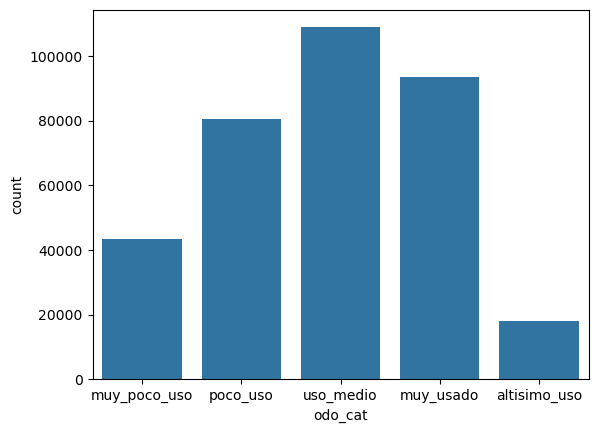

In [18]:
sns.countplot(data=df, x='odo_cat', order=['muy_poco_uso', 'poco_uso', 'uso_medio', 'muy_usado', 'altisimo_uso'])

In [19]:
# Feature Engineering
df['is_luxury'] = df['manufacturer'].isin(['audi', 'bmw', 'mercedes-benz', 'lexus', 'cadillac', 'infiniti', 'acura', 'jaguar', 'volvo', 'land rover'])

df['age_car'] = 2025 - df['year']
df.loc[df['age_car'] == 0, 'age_car'] = 1
df['km_per_year'] = df['odometer'] / df['age_car']


df['km_per_year'] = df['odometer'] / df['age_car']

mapping_condition = {
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0

}

df['condition_score'] = df['condition'].map(mapping_condition)

In [20]:
selected_features = ['year', 'odometer', 'fuel', 'title_status', 'manufacturer',  'odo_cat', 'model', 'is_luxury', 'age_car', 'km_per_year']

In [21]:
numeric_features = ['year', 'odometer', 'age_car', 'km_per_year']
categorical_features = ['fuel', 'title_status', 'manufacturer', 'model', 'odo_cat']


preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['price'], test_size=0.2, random_state=42)

In [23]:
# Preprocesar SOLO el train
X_train_prep = preprocess.fit_transform(X_train)

# Preprocesar SOLO el test (para evaluación final)
X_test_prep = preprocess.transform(X_test)


In [24]:
print(np.isnan(X_train_prep).sum())
print(X_train_prep.dtype)

print(np.isinf(X_train_prep).sum())

0
float64
0


In [ ]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    model = XGBRegressor(
        **params,
        tree_method="hist", 
        #device="cuda",
        device="cpu",      
        eval_metric="rmse"
    )
    
    
    score = cross_val_score(
        model,
        X_train_prep,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return score

def run_study(study, n_trials):
    for _ in tqdm(range(n_trials)):
        study.optimize(objective, n_trials=1, catch=(Exception,))

study = optuna.create_study(direction="maximize")
run_study(study, n_trials=50)

print(study.best_params)

[I 2025-12-03 07:36:39,157] A new study created in memory with name: no-name-b1906737-65ab-4af1-98ba-2cc6cbebec09
 10%|█         | 5/50 [01:15<12:55, 17.23s/it][W 2025-12-03 07:38:37,188] Trial 5 failed with parameters: {'n_estimators': 360, 'max_depth': 18, 'learning_rate': 0.25687245441539086, 'min_child_weight': 1, 'subsample': 0.5875830529664254, 'colsample_bytree': 0.6884796709028977} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3376/593069020.py", line 24, in objective
    score = cross_val_score(
            ^^^^^^^^^^^^^^^^
  File "/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/h

KeyboardInterrupt: 